# Mounting Google Drive File in Colab to access files

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Libraries

In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.utils import load_img
from tensorflow.keras import layers, regularizers, initializers, Sequential
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
from PIL import Image

# Loading Data

In [33]:
data_path = r'/content/drive/MyDrive/Brain Tumor MRI Image Classification/Tumour-20251124T124157Z-1-001/Tumour'

In [34]:
print('data_path :', data_path)
print('exists :', Path(data_path).exists())

data_path : /content/drive/MyDrive/Brain Tumor MRI Image Classification/Tumour-20251124T124157Z-1-001/Tumour
exists : True


# EDA

In [35]:
main_f = os.listdir(data_path)
sub_f = [item for item in ['test', 'valid', 'train'] if item in main_f]

In [36]:
main_f

['README.dataset.txt', 'train', 'test', 'valid']

In [37]:
print('Number of Folders :', len(sub_f))
print('The Folders are :', sub_f)

Number of Folders : 3
The Folders are : ['test', 'valid', 'train']


In [38]:
sub_f

['test', 'valid', 'train']

**Dataset Info**

In [39]:
tot_imgs = 0 # To count the total number of images

for fold in sub_f:
  fold_path = os.path.join(data_path, fold)
  tumor_classes = sorted([f for f in os.listdir(fold_path) if os.path.isdir(os.path.join(fold_path, f))])
  print(f'{fold.upper()} - Tumor Classes :', tumor_classes)

  no_of_imgs = 0 # To count the number of images in each folder
  for tumor_class in tumor_classes: # Loop through each tumor classes
    class_path = os.path.join(fold_path, tumor_class)
    img_count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg'))])
    no_of_imgs += img_count
    print(f'{tumor_class} : {img_count} images')

  print('Total number of images :', no_of_imgs)
  tot_imgs += no_of_imgs
  print()
print(f'Total number of images present in the datset : {tot_imgs}')

TEST - Tumor Classes : ['glioma', 'meningioma', 'no_tumor', 'pituitary']
glioma : 80 images
meningioma : 63 images
no_tumor : 49 images
pituitary : 54 images
Total number of images : 246

VALID - Tumor Classes : ['glioma', 'meningioma', 'no_tumor', 'pituitary']
glioma : 161 images
meningioma : 124 images
no_tumor : 99 images
pituitary : 118 images
Total number of images : 502

TRAIN - Tumor Classes : ['glioma', 'meningioma', 'no_tumor', 'pituitary']
glioma : 564 images
meningioma : 358 images
no_tumor : 335 images
pituitary : 438 images
Total number of images : 1695

Total number of images present in the datset : 2443


**Visualizing a sample MRI Image**

In [40]:
def view_image(data_path, fold, tumor_class, img_ind):
  fold_path = os.path.join(data_path, fold, tumor_class)
  img_files = [f for f in os.listdir(fold_path) if f.lower().endswith(('.png', '.jpg'))]

  if img_ind < 0 or img_ind >= len(img_files): # To check the requested index is valid
    print(f'Error : Image Index {img_ind} out of range in {tumor_class} of {fold}')
    return

  img_f = img_files[img_ind]
  img_path = os.path.join(fold_path, img_f)

  image = load_img(img_path) # Using load_img from keras utils
  plt.imshow(image)
  plt.title(f'{fold} - {tumor_class} - Image {img_ind + 1} \n Filename : {img_f}')
  plt.axis('off') # Hiding the axis for cleaner display
  plt.show()

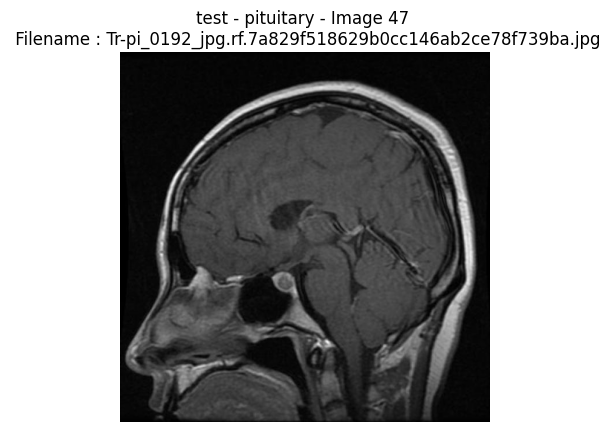

In [41]:
view_image(data_path, 'test', 'pituitary', 46)

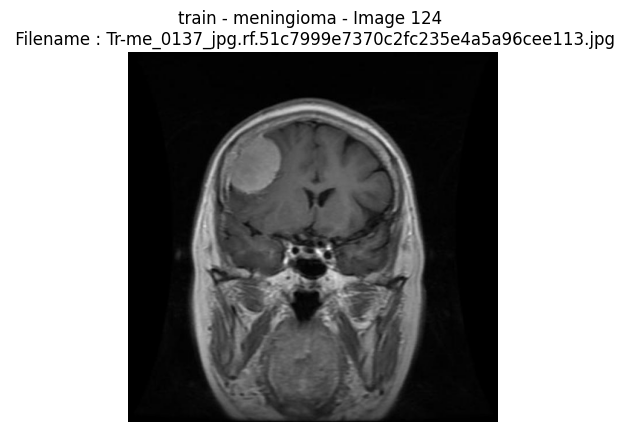

In [42]:
view_image(data_path, 'train', 'meningioma', 123)

**Visualizing sample images from each Tumor class**

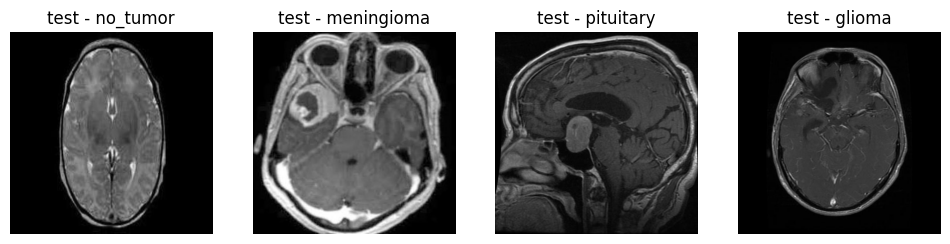

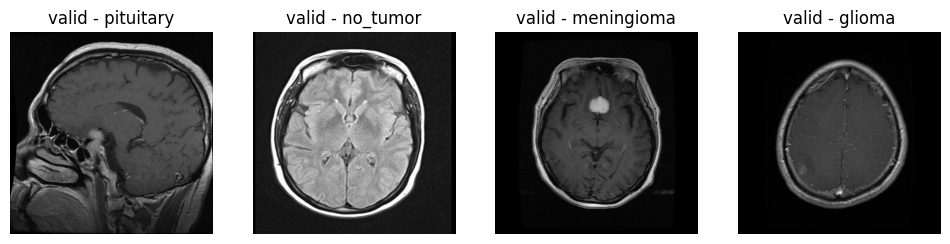

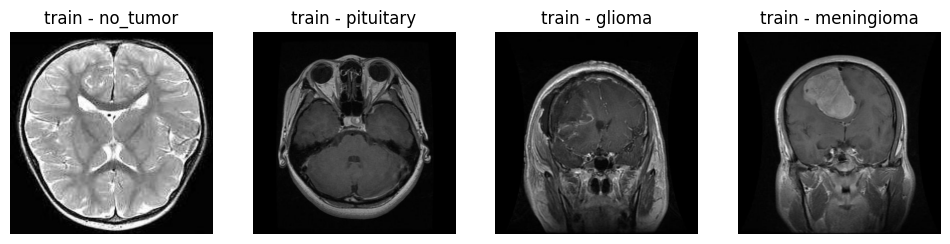

In [43]:
for fold in sub_f:
    fold_path = os.path.join(data_path, fold)
    tumor_classes = [f for f in os.listdir(fold_path) if os.path.isdir(os.path.join(fold_path, f))]

    plt.figure(figsize = (12,8))
    for i, tumor_class in enumerate(tumor_classes[:4]):
        class_path = os.path.join(fold_path, tumor_class)
        img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png'))]

        if img_files:
            img_path = os.path.join(class_path, img_files[7]) # img_files[7] --> 8th image of that folder
            image = load_img(img_path)
            plt.subplot(1,4,i+1) # i+1 --> Position of the subplot
            plt.imshow(image)
            plt.title(f'{fold} - {tumor_class}')
            plt.axis('off')
    plt.show()

**Image Resolution Analaysis**

In [44]:
print('Image Resolution Analysis :')
print()
all_sizes = [] # List to store image sizes (width, height) across all folds

for fold in sub_f:
    fold_path = os.path.join(data_path, fold)
    tumor_classes = [f for f in os.listdir(fold_path) if os.path.isdir(os.path.join(fold_path, f))]

    fold_sizes = [] # List to store image sizes for this fold
    for tumor_class in tumor_classes:
        class_path = os.path.join(fold_path, tumor_class)
        img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png'))][:10]

        for img_file in img_files:
            try:
                img_path = os.path.join(class_path, img_file)
                img = load_img(img_path)
                fold_sizes.append(img.size)
            except:
                pass # To skip if image cannot be loaded or facing errors

    all_sizes.extend(fold_sizes)
    if fold_sizes:
        widths, heights = zip(*fold_sizes) # To separate width and height values
        print(f'{fold.upper()} : {len(fold_sizes)} images checked')
        print(f'Width : {min(widths):3d} - {max(widths):3d} px (Avg : {np.mean(widths):.0f})')
        print(f'Height : {min(heights):3d} - {max(heights):3d} px (Avg : {np.mean(heights):.0f})\n')

widths, heights = zip(*all_sizes)
print('Overall Dataset :')
print(f'Width range : {min(widths):3d} - {max(widths):3d} px')
print(f'Height range : {min(heights):3d} - {max(heights):3d}')
print(f'Most Common : {max(set(widths), key = widths.count)} x {max(set(heights), key = heights.count)}')

Image Resolution Analysis :

TEST : 40 images checked
Width : 640 - 640 px (Avg : 640)
Height : 640 - 640 px (Avg : 640)

VALID : 40 images checked
Width : 640 - 640 px (Avg : 640)
Height : 640 - 640 px (Avg : 640)

TRAIN : 40 images checked
Width : 640 - 640 px (Avg : 640)
Height : 640 - 640 px (Avg : 640)

Overall Dataset :
Width range : 640 - 640 px
Height range : 640 - 640
Most Common : 640 x 640


**Class Imbalance Analysis**

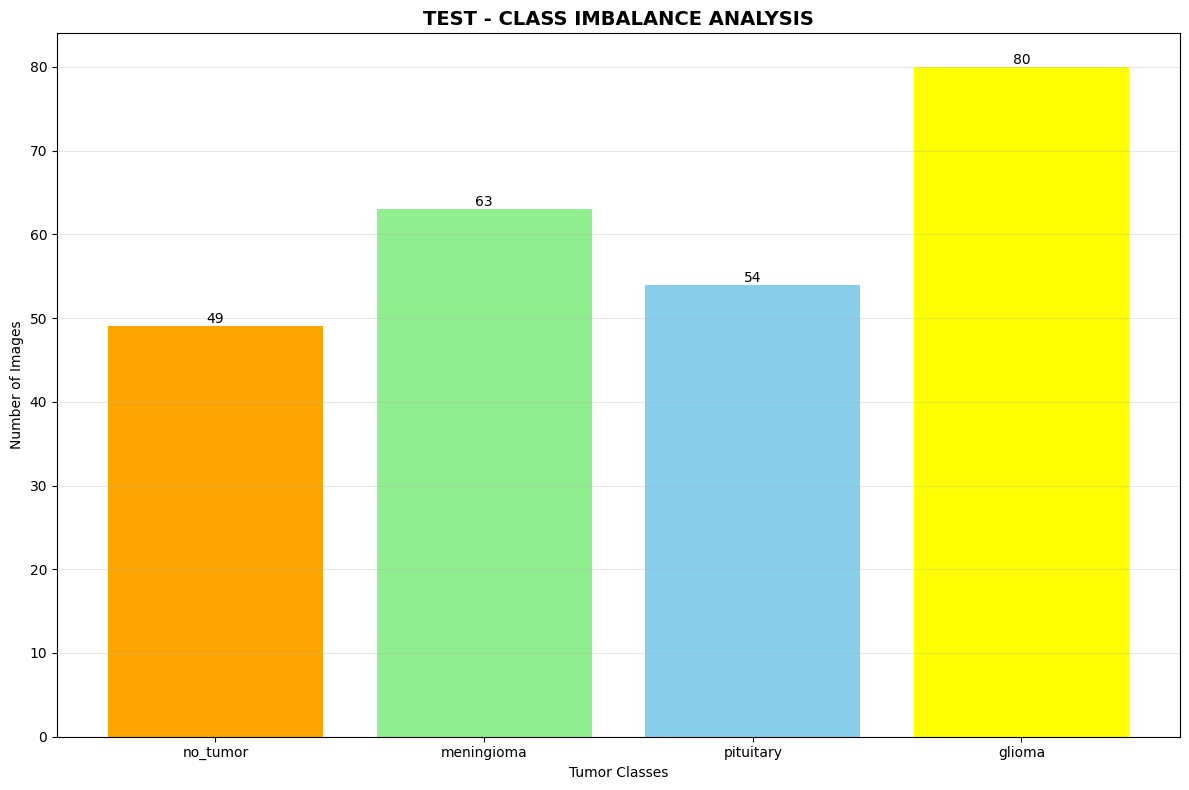

TEST - MAX : 80, MIN : 49, Balance : 1.6x


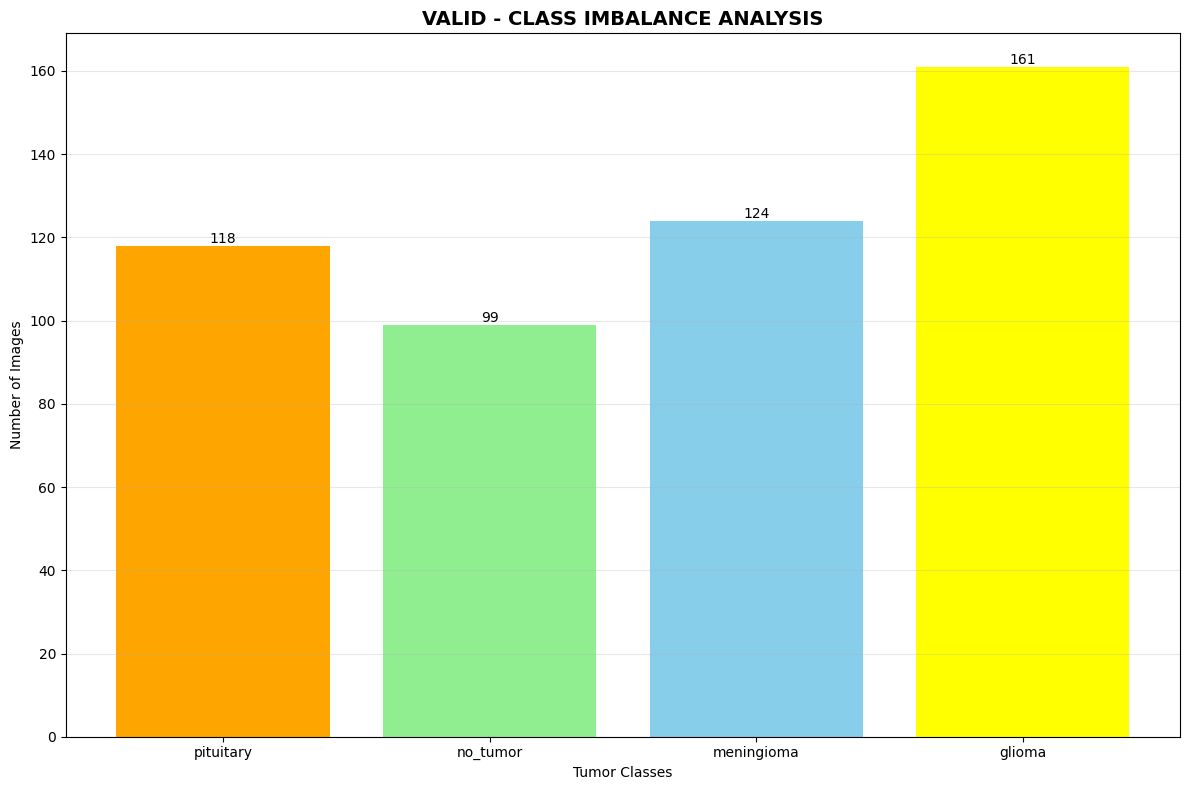

VALID - MAX : 161, MIN : 99, Balance : 1.6x


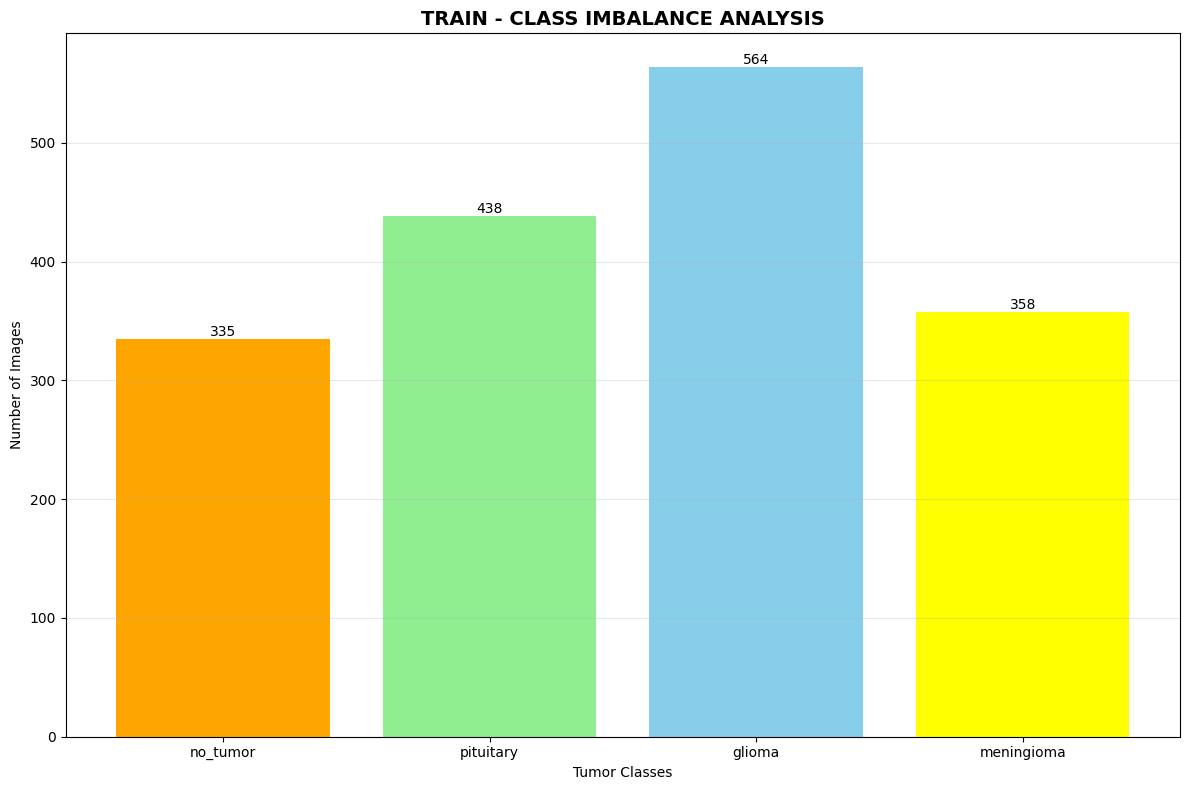

TRAIN - MAX : 564, MIN : 335, Balance : 1.7x


In [45]:
cls_count = {} # To store image counts of each folder and class
for fold in sub_f:
    fold_path = os.path.join(data_path, fold)
    tumor_classes = [f for f in os.listdir(fold_path) if os.path.isdir(os.path.join(fold_path, f))]
    cls_count[fold] = {} # To store the number of images in each folder --> class

    for tumor_class in tumor_classes:
        class_path = os.path.join(fold_path, tumor_class)
        img_count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png'))])
        cls_count[fold][tumor_class] = img_count

def counts_of_bars(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha = 'center', va = 'bottom') # To add count numbers above bars

for split, counts in cls_count.items():
    plt.figure(figsize = (12,8))
    classes = list(counts.keys()) # List of tumor class names
    numbers = list(counts.values()) # Number of images per class

    # Bar chart for each splits - classes
    bars = plt.bar(classes, numbers, color = ['orange', 'lightgreen', 'skyblue', 'yellow'])
    counts_of_bars(plt.gca(), bars) # To activate the option to place the total counts above each bars

    plt.title(f'{split.upper()} - CLASS IMBALANCE ANALYSIS', fontsize = 14, fontweight = 'bold')
    plt.xlabel('Tumor Classes')
    plt.ylabel('Number of Images')
    plt.grid(axis = 'y', alpha = 0.3)
    plt.tight_layout()
    plt.show()

    print(f'{split.upper()} - MAX : {max(numbers)}, MIN : {min(numbers)}, Balance : {max(numbers)/min(numbers):.1f}x')

**Tumor Class Distribution**

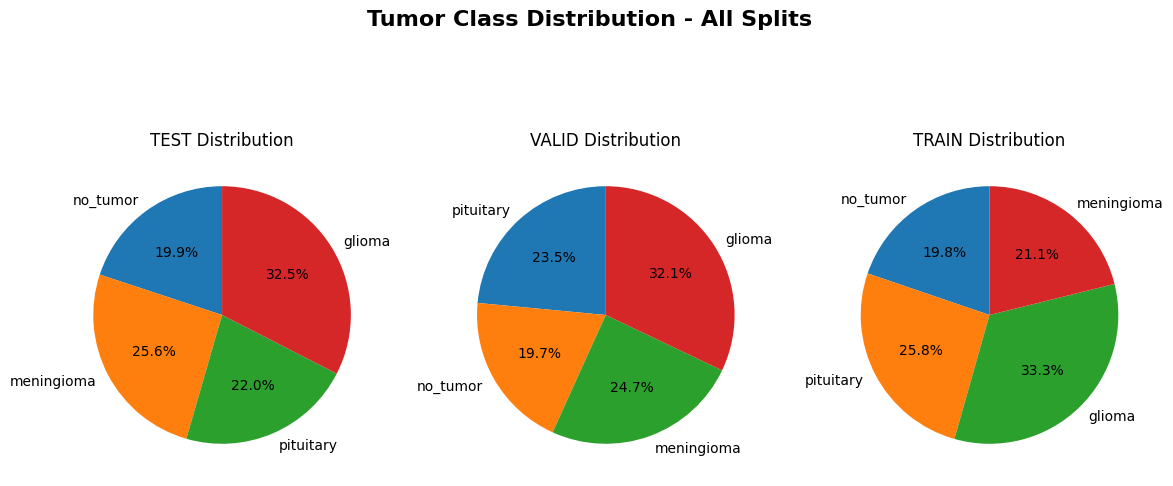

In [46]:
fig, axes = plt.subplots(1, 3, figsize = (12,6))

i = 0 # Index to track which subplot we are using

for split, counts in cls_count.items():
    axes[i].pie(counts.values(), labels = counts.keys(), autopct = '%1.1f%%', startangle = 90) # startangle = 90 --> Makes the pie chart start at top (90 degree)
    axes[i].set_title(f'{split.upper()} Distribution')
    i += 1 # To move to the next subplot index

plt.suptitle('Tumor Class Distribution - All Splits', fontsize = 16, fontweight = 'bold')
plt.tight_layout()
plt.show()

**Distribution of Image Dimensions**

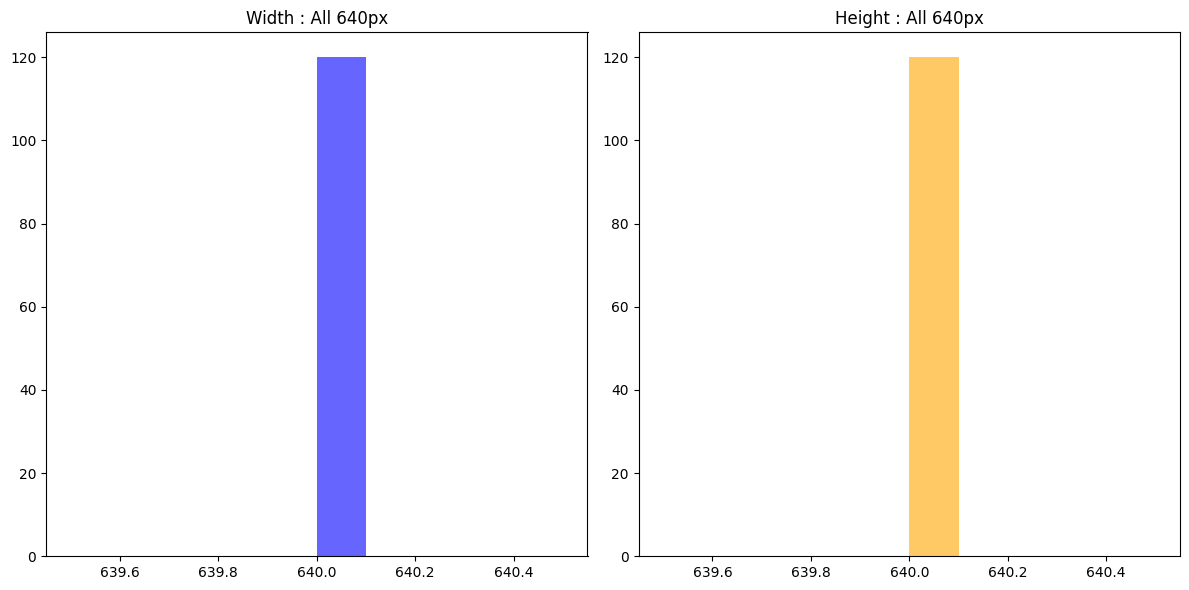

In [47]:
plt.figure(figsize = (12,6))

# 1st subplot - histogram of image widths
plt.subplot(1,2,1)
plt.hist([w for w, h in all_sizes], bins = 10, color = 'blue', alpha = 0.6) # alpha = transparency
plt.title('Width : All 640px')

# 2nd subplot - histogram of image heights
plt.subplot(1,2,2)
plt.hist([h for w, h in all_sizes], bins = 10, color = 'orange', alpha = 0.6)
plt.title('Height : All 640px')
plt.tight_layout()
plt.show()

# Preparing Dataset with Preprocessing

In [48]:
# Loading class label CSV files for each dataset split (train, test, validation)
# These CSVs usually contain image filenames and their corresponding class labels
train_df = pd.read_csv(r"/content/drive/MyDrive/Brain Tumor MRI Image Classification/Tumour-20251124T124157Z-1-001/Tumour/train/train_classes.csv")
test_df = pd.read_csv(r"/content/drive/MyDrive/Brain Tumor MRI Image Classification/Tumour-20251124T124157Z-1-001/Tumour/test/test_classes.csv")
valid_df = pd.read_csv(r"/content/drive/MyDrive/Brain Tumor MRI Image Classification/Tumour-20251124T124157Z-1-001/Tumour/valid/valid_classes.csv")

# Defining directory paths for each dataset split
train_dir = r"/content/drive/MyDrive/Brain Tumor MRI Image Classification/Tumour-20251124T124157Z-1-001/Tumour/train"
valid_dir = r"/content/drive/MyDrive/Brain Tumor MRI Image Classification/Tumour-20251124T124157Z-1-001/Tumour/valid"
test_dir = r"/content/drive/MyDrive/Brain Tumor MRI Image Classification/Tumour-20251124T124157Z-1-001/Tumour/test"


img_size = (224, 224) # resizing all images to 224 x 224 pixels
batch_size = 32 # number of images per batch during training
cls_names = [' Glioma', ' Meningioma', ' No Tumor', ' Pituitary']
cls_names = [c.strip() for c in cls_names]
num_cls = len(cls_names)

print(f'Classes : {cls_names}, Total No of Classes : {num_cls}')

Classes : ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'], Total No of Classes : 4


In [49]:
def dataset_from_csv(df, image_dir, img_size = (224,224), batch_size = 32, shuffle = True,
                     augment = False, preprocess_fn = None, cache_in_memory = True):
    df = df.copy() # Making a copy to not modify the original df
    df.columns = [c.strip() for c in df.columns] # Strip extra spaces from column names for consistency'
    class_cols = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    folder_names = [c.strip().lower().replace(' ', '_') for c in class_cols]

    # Function to build full image path for each row in the dataframe
    def make_path(row):
        idx = int(row[class_cols].values.argmax())
        folder = folder_names[idx]
        filename = str(row['filename']).strip()
        return os.path.join(image_dir, folder, filename) # Full path to image

    # Applying path-building function to each row and store in new column
    df['filepath'] = df.apply(make_path, axis = 1)

    # To check missing files(paths that dont exist)
    missing = df.loc[~df['filepath'].apply(os.path.exists), 'filepath']
    if not missing.empty:
        print('Missing Files (first 10) :', missing.head(10).tolist())
        raise FileNotFoundError(f'{len(missing)} image files not found.')

    # Extracting file paths and labels as numpy arrays
    file_paths = df['filepath'].astype(str).values
    labels = df[class_cols].values.astype('float32')

    # Create a TensorFlow dataset from file paths and labels
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    def load_img(path, label):
        img = tf.io.read_file(path) # Reading the image file
        img = tf.image.decode_image(img, channels = 3, expand_animations = False) # Decoding into tensor
        img = tf.image.resize(img, img_size, method = 'bilinear', antialias = True) # Resizing images
        img = tf.cast(img, tf.float32)
        img.set_shape([img_size[0], img_size[1], 3]) # Enforcing the shape (height, width, 3(RGB))

        # Normalising - Applying preprocessing
        if preprocess_fn is None:
                                img = img / 255.0 # Scaling pixel values from 0 to 1
        else:
                                img = preprocess_fn(img)
        return img, label

    # Map preprocessing function to dataset (parallelized for speed)
    ds = ds.map(load_img, num_parallel_calls = tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size = 1000, seed = 56)

    # Cache dataset in memory for faster access during training
    if cache_in_memory:
        ds = ds.cache()

    # Batch dataset (group images into batches of size batch_size)
    ds = ds.batch(batch_size)
    # Prefetch batches for performance (overlaps data loading with training)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds # Returning the prepared dataset

In [50]:
# Creating TensorFlow dataset for training, validation and testing
train_ds = dataset_from_csv(train_df, train_dir, img_size, batch_size, shuffle = True, preprocess_fn = None, cache_in_memory = True)
valid_ds = dataset_from_csv(valid_df, valid_dir, img_size, batch_size, shuffle = False, preprocess_fn = None, cache_in_memory = False)
test_ds = dataset_from_csv(test_df, test_dir, img_size, batch_size, shuffle = False, preprocess_fn = None, cache_in_memory = False)

/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use

In [51]:
 '''Taking one batch of images and labels from the training dataset to
print the min and max pixel values in this batch of images'''
imgs, lbls = next(iter(train_ds))
print("images min/max:", float(tf.reduce_min(imgs)), float(tf.reduce_max(imgs)))

images min/max: 0.0 1.000000238418579


In [52]:
print('No of batches in Train Dataset :', len(train_ds))
print(f'Batch Shape : {train_ds.element_spec}')
print()

print('No of batches in Valid Dataset :', len(valid_ds))
print()

print('No of batches in Test Dataset :', len(test_ds))

No of batches in Train Dataset : 53
Batch Shape : (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))

No of batches in Valid Dataset : 16

No of batches in Test Dataset : 8


# Data Augmentation

In [53]:
# Defining a sequential data augmentation pipeline using Keras preprocessing layers
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'), # To randomly flipping images horizontally (left to right)
    tf.keras.layers.RandomRotation(0.1), # To randomly rotating images by up to ±10% of 360°
    tf.keras.layers.RandomZoom(0.1), # To randomly zoom into images by up to 10%
    tf.keras.layers.RandomBrightness(0.1), # To randomly adjust brightness by up to ±10%
    tf.keras.layers.RandomTranslation(0.1, 0.1), # To randomly translate (shift) images horizontally and vertically by up to 10%
    tf.keras.layers.RandomContrast(0.1), # To randomly adjust contrast by up to ±10%
    tf.keras.layers.RandomCrop(200, 200) # To randomly crop images to size (200,200) from the original (224,224)
])

In [54]:
''' Unbatching the training dataset, this breaks the dataset back into individual (image, label) pairs
its needed because augmentation is applied per-image, not per-batch'''
train_ds = train_ds.unbatch()

train_ds = train_ds.map(lambda x, y: (data_aug(x, training=True), y),
                        num_parallel_calls=tf.data.AUTOTUNE)
# Applying data augmentation to each image in the training dataset
# lambda x,y → returns (augmented_image, label)
# data_aug(x, training=True) → applies the augmentation pipeline defined earlier
# num_parallel_calls=tf.data.AUTOTUNE → parallelize for speed

train_ds = train_ds.batch(batch_size, drop_remainder=False).prefetch(tf.data.AUTOTUNE)
# Re-batching the dataset after augmentation
# drop_remainder=False → keep last batch even if it's smaller than batch_size
# prefetch → overlap data loading with training for efficiency

valid_ds = valid_ds  # already batched in dataset_from_csv
test_ds  = test_ds   # already batched in dataset_from_csv

In [55]:
# ResNet50 datasets
train_ds_resnet = dataset_from_csv(
    train_df, train_dir, img_size, batch_size,
    shuffle=True, preprocess_fn=resnet_preprocess        # Applying ResNet50-specific preprocessing (scales pixels as required by ResNet)
).map(lambda x, y: (tf.image.resize(x, img_size), y))    # To ensure images are resized exactly to img_size after preprocessing

valid_ds_resnet = dataset_from_csv(
    valid_df, valid_dir, img_size, batch_size,
    shuffle=False, preprocess_fn=resnet_preprocess       # No shuffle for validation data (deterministic evaluation)
).map(lambda x, y: (tf.image.resize(x, img_size), y))

test_ds_resnet = dataset_from_csv(
    test_df, test_dir, img_size, batch_size,
    shuffle=False, preprocess_fn=resnet_preprocess       # No shuffle for test data
).map(lambda x, y: (tf.image.resize(x, img_size), y))    # Ensure resizing after preprocessing

# MobileNetV2 datasets
train_ds_mobilenet = dataset_from_csv(
    train_df, train_dir, img_size, batch_size,
    shuffle=True, preprocess_fn=mobilenet_preprocess     # Applying MobileNetV2-specific preprocessing
).map(lambda x, y: (tf.image.resize(x, img_size), y))

valid_ds_mobilenet = dataset_from_csv(
    valid_df, valid_dir, img_size, batch_size,
    shuffle=False, preprocess_fn=mobilenet_preprocess    # No shuffle for validation data
).map(lambda x, y: (tf.image.resize(x, img_size), y))

test_ds_mobilenet = dataset_from_csv(
    test_df, test_dir, img_size, batch_size,
    shuffle=False, preprocess_fn=mobilenet_preprocess    # No shuffle for test data
).map(lambda x, y: (tf.image.resize(x, img_size), y))    # Ensure resizing after preprocessing


/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use

# Model Building

Custom CNN

In [56]:
# Cell 4 — improved custom CNN (keeps your architecture but with practical tweaks)

cust_cnn = Sequential(name='cust_cnn')
cust_cnn.add(layers.Input(shape=(img_size[0], img_size[1], 3)))  # Input layer: expects images of shape (224,224,3)

# Block 1
cust_cnn.add(layers.Conv2D(32, 3, padding='same', activation='relu',
                           kernel_initializer='he_normal',
                           kernel_regularizer=regularizers.l2(1e-4)))  # L2 regularization to reduce overfitting
cust_cnn.add(layers.BatchNormalization())  # Stabilizing activations and speeding up the convergence
cust_cnn.add(layers.Conv2D(32, 3, padding='same', activation='relu',
                           kernel_initializer='he_normal'))
cust_cnn.add(layers.MaxPooling2D(2))  # Downsample feature maps
cust_cnn.add(layers.Dropout(0.25))  # Randomly dropping 25% of neurons to prevent overfitting

# Block 2
cust_cnn.add(layers.Conv2D(64, 3, padding='same', activation='relu',
                           kernel_initializer='he_normal'))
cust_cnn.add(layers.BatchNormalization())
cust_cnn.add(layers.Conv2D(64, 3, padding='same', activation='relu',
                           kernel_initializer='he_normal'))
cust_cnn.add(layers.MaxPooling2D(2))
cust_cnn.add(layers.Dropout(0.25))

# Block 3
cust_cnn.add(layers.Conv2D(128, 3, padding='same', activation='relu',
                           kernel_initializer='he_normal'))
cust_cnn.add(layers.BatchNormalization())
cust_cnn.add(layers.Conv2D(128, 3, padding='same', activation='relu',
                           kernel_initializer='he_normal'))
cust_cnn.add(layers.MaxPooling2D(2))
cust_cnn.add(layers.Dropout(0.25))

# GlobalAveragePooling reduces each feature map to a single value
# → fewer parameters compared to Flatten, helps avoid overfitting
cust_cnn.add(layers.GlobalAveragePooling2D())
cust_cnn.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal')) # Dense layer with 512 units for high-level feature learning
cust_cnn.add(layers.BatchNormalization())
cust_cnn.add(layers.Dropout(0.5)) # Stronger dropout at the head

cust_cnn.add(layers.Dense(num_cls, activation='softmax'))
# Dense(num_cls) → creates one output neuron per tumor category
# Softmax converts raw logits into a probability distribution across classes
# Each output value is between 0 and 1, and all values sum to 1
# The class with the highest probability is the predicted tumor type


cust_cnn.summary()


Model: "cust_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 358,052 (1.37 MB)

 Trainable params: 356,580 (1.36 MB)

 Non-trainable params: 1,472 (5.75 KB)

# Transfer Learning

In [57]:
# Cell 1 — define image shape
img_shape = img_size + (3,)  # img_size is (224,224), so img_shape becomes (224,224,3) for RGB images

# Base models
resnet_mod = tf.keras.applications.ResNet50(
    weights='imagenet',  # Loading the reactions (weights) that this model learned from ImageNet, instead of starting from scratch
    include_top=False,  # include_top=False → remove the original classification head
    input_shape=img_shape
)

mobilenet_mod = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=img_shape
)

# Head builder
def create_head(base_model, model_name):
    base_model.trainable = False

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x) #GlobalAveragePooling → To compress feature maps into a single vector
    x = tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x) # Dense layer for high-level feature learning
    x = tf.keras.layers.BatchNormalization()(x)   # Added for stability and improving convergence
    x = tf.keras.layers.Dropout(0.5)(x) # Dropout → randomly dropping 50% of neurons to prevent overfitting
    outputs = tf.keras.layers.Dense(num_cls, activation='softmax')(x) # Softmax → outputs probabilities across classes
    model = tf.keras.Model(inputs = base_model.input, outputs = outputs, name = model_name) # To build full model combining base + head

    return model

# Building models
resnet_model = create_head(resnet_mod, 'resnet_tumor')
mobilenet_model = create_head(mobilenet_mod, 'mobilenet_tumor')

print('ResNet50 model:')
resnet_model.summary()
print('\nMobileNetV2 model:')
mobilenet_model.summary()

ResNet50 model:


Model: "resnet_tumor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,640,900 (94.00 MB)

 Trainable params: 1,052,164 (4.01 MB)

 Non-trainable params: 23,588,736 (89.98 MB)


MobileNetV2 model:


Model: "mobilenet_tumor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,917,956 (11.13 MB)

 Trainable params: 658,948 (2.51 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

**Optionally unfreezing top layers for fine-tuning after initial training**

In [58]:
def unfreeze_top_layers(model, fraction=0.2):
    base_model = model.layers[0] # Getting the base model
    base_model.trainable = True # Allowing the base model to be trainable

    num_layers = len(base_model.layers) # Counting how many layers are in the base model
    num_unfreeze = max(1, int(num_layers * fraction)) # To decide how many layers to unfreeze based on the fraction given

    for layer in base_model.layers[:-num_unfreeze]: # Freezing all layers except the top 'num_unfreeze' layers
        layer.trainable = False
    for layer in base_model.layers[-num_unfreeze:]: # Unfreezing the top 'num_unfreeze' layers
        layer.trainable = True

    print(f'{model.name}: Ready for fine-tuning - top {num_unfreeze}/{num_layers} layers unfrozen')

# Model Training

In [59]:
# @title
# Set seeds for reproducibility
tf.random.set_seed(56) # Fix TensorFlow random seed so results are consistent across runs
np.random.seed(56) # Fix NumPy random seed for reproducibility

# Training parameters
EPOCHS = 20 # Number of training epochs for each model
model_dir = Path("/content/drive/MyDrive/models/brain_tumor_cls") # Directory to save models
model_dir.mkdir(parents=True, exist_ok=True) # Creating directory if it doesn’t exist

# Optimizer and loss
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=1e-3)
LOSS = "categorical_crossentropy" # Loss for multi-class classification (softmax outputs)

# Models + datasets dictionary
# Each entry: model name → (model object, training dataset, validation dataset)
models_and_data = {
    "Custom_CNN": (cust_cnn, train_ds, valid_ds),
    "ResNet50": (resnet_model, train_ds_resnet, valid_ds_resnet),
    "MobileNetV2": (mobilenet_model, train_ds_mobilenet, valid_ds_mobilenet),
}

# File paths for saving models
final_h5_files = {name: model_dir / f"best_{name}.h5" for name in models_and_data}
keras_files = {name: model_dir / f"best_{name}.keras" for name in models_and_data}
weights_files = {name: model_dir / f"best_{name}.weights.h5" for name in models_and_data}

# Try loading saved models
loaded = False
if all(p.exists() for p in final_h5_files.values()): # Checking if all saved models exist
    print("Found Saved Models -> Loading...")
    try:
        cust_cnn = tf.keras.models.load_model(str(final_h5_files["Custom_CNN"]))
        resnet_model = tf.keras.models.load_model(str(final_h5_files["ResNet50"]))
        mobilenet_model = tf.keras.models.load_model(str(final_h5_files["MobileNetV2"]))
        print("All Models Loaded!! -> Skipping Training")
        loaded = True
    except Exception as e:
        # Back to training, if loading fails
        print("Load Failed!! -> Training Begins... Exception :", e)
        loaded = False

# Training loop
histories = {} # Dictionary to store training histories for each model
if not loaded: # Only train if models weren’t successfully loaded
    print(f"Training {EPOCHS} epochs -> Models saved in : {model_dir}")
    for name, (model, train_data, valid_data) in models_and_data.items():
        print(f"\nTraining {name}...")

        # Compiling each model with fresh optimizer and loss
        model.compile(optimizer=Adam(learning_rate=1e-3), loss=LOSS, metrics=["accuracy"])
        print(f'{name} compiled successfully')

        # Fit model on training data with validation and callbacks
        history = model.fit(
            train_data,
            validation_data=valid_data,
            epochs=EPOCHS,
            callbacks=[
                # Stop training early if validation loss doesnt improve fpr 5 epochs
                tf.keras.callbacks.EarlyStopping(
                    monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
                ),
                # Saving best weights based on validation loss during training
                tf.keras.callbacks.ModelCheckpoint(
                    str(weights_files[name]),
                    monitor="val_loss",
                    save_best_only=True,
                    save_weights_only=True,
                    verbose=1,
                ),
                # Reducing learning rate if validation loss plateaus for 3 epochs
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor="val_loss", factor=0.5, patience=3, verbose=1
                ),
            ],
            verbose=1,
        )

        histories[name] = history
        model.save(str(keras_files[name]))
        model.save(str(final_h5_files[name]), save_format="h5")

        print(f"Best {name} -> {final_h5_files[name].name} (HDF5) and {keras_files[name].name} (Keras)")

print(f"\nDirectory : {model_dir}")
print("Models Delivered :")
for name in models_and_data:
    print(f" -> best_{name}.h5")

Found Saved Models -> Loading...


All Models Loaded!! -> Skipping Training

Directory : /content/drive/MyDrive/models/brain_tumor_cls
Models Delivered :
 -> best_Custom_CNN.h5
 -> best_ResNet50.h5
 -> best_MobileNetV2.h5


# Model Evaluation


Evaluating Custom_CNN...
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step
              precision    recall  f1-score   support

      Glioma       0.33      1.00      0.49        80
  Meningioma       0.00      0.00      0.00        63
    No Tumor       0.00      0.00      0.00        49
   Pituitary       0.00      0.00      0.00        54

    accuracy                           0.33       246
   macro avg       0.08      0.25      0.12       246
weighted avg       0.11      0.33      0.16       246



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


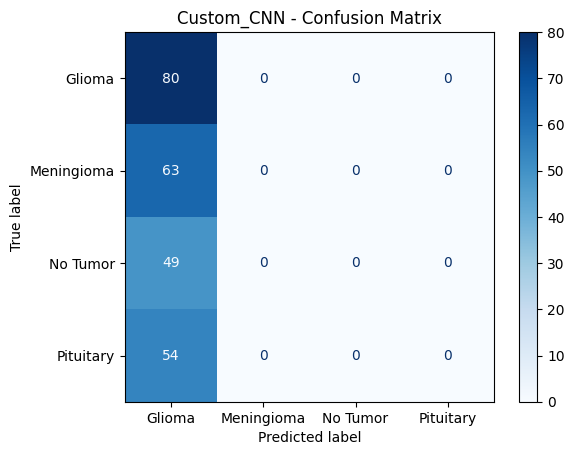


Evaluating ResNet50...
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 308ms/step
              precision    recall  f1-score   support

      Glioma       0.93      0.97      0.95        80
  Meningioma       0.79      0.92      0.85        63
    No Tumor       0.97      0.76      0.85        49
   Pituitary       0.98      0.93      0.95        54

    accuracy                           0.91       246
   macro avg       0.92      0.89      0.90       246
weighted avg       0.91      0.91      0.91       246



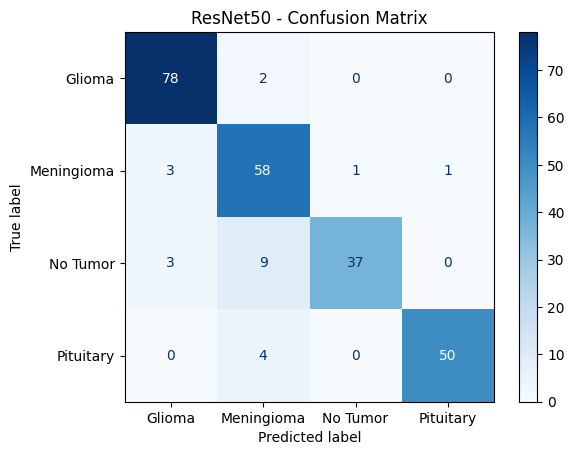


Evaluating MobileNetV2...
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
              precision    recall  f1-score   support

      Glioma       0.93      0.97      0.95        80
  Meningioma       0.89      0.90      0.90        63
    No Tumor       0.96      0.90      0.93        49
   Pituitary       1.00      0.96      0.98        54

    accuracy                           0.94       246
   macro avg       0.94      0.94      0.94       246
weighted avg       0.94      0.94      0.94       246



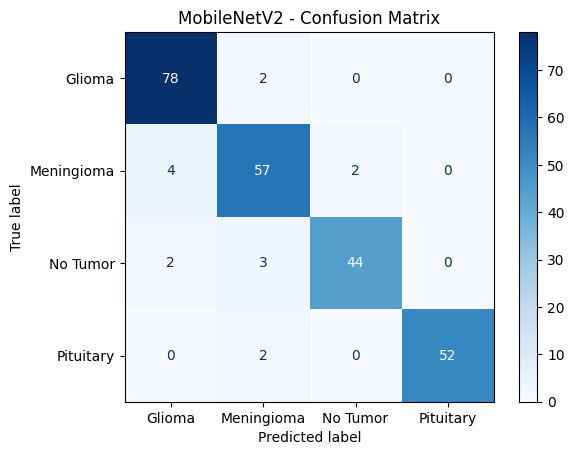

In [60]:
# Loading the best saved models(hdf5 format)
cust_cnn_best = load_model('/content/drive/MyDrive/models/brain_tumor_cls/best_Custom_CNN.h5')
resnet_best = load_model('/content/drive/MyDrive/models/brain_tumor_cls/best_ResNet50.h5')
mobilenet_best = load_model('/content/drive/MyDrive/models/brain_tumor_cls/best_MobileNetV2.h5')

# Organizing models into a dictionary for easy looping
models = {
    "Custom_CNN": cust_cnn_best,
    "ResNet50": resnet_best,
    "MobileNetV2": mobilenet_best
}
# Matching each model with its corresponding test dataset
datasets = {
    "Custom_CNN": test_ds,
    "ResNet50": test_ds_resnet,
    "MobileNetV2": test_ds_mobilenet
}
# Loop through each model for evaluation
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    test_data = datasets[name]

    # Extracting true labels from the test datset
    y_true = np.concatenate([y for _, y in test_data], axis=0) # Concenate all labels into one array
    if y_true.ndim > 1:   # convert one-hot to integers if needed
        y_true = np.argmax(y_true, axis=1)

    # Get model Predictions
    y_pred_probs = model.predict(test_data) # Predict probabilities for each class
    y_pred = np.argmax(y_pred_probs, axis=1) # Convert probabilities to predicted class indices

    # Metrics
    print(classification_report(y_true, y_pred, target_names=cls_names))

    # Confusion Matrix
    # Summarizes how many samples were correctly/incorrectly classified per class
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()


In [61]:
data = {
    "Model": ["Custom CNN", "ResNet50", "MobileNetV2"],
    "Accuracy": [0.33, 0.92, 0.91],
    "Macro Precision": [0.08, 0.93, 0.91],
    "Macro Recall": [0.25, 0.92, 0.91],
    "Macro F1": [0.12, 0.92, 0.91],
    "Notes": [
        "Underfit, predicts only Glioma",
        "Best accuracy, strong balance",
        "Nearly as good, lighter model"
    ]
}

**Evaluation Summary**

In [62]:
summary_df = pd.DataFrame(data)
summary_df

,Model,Accuracy,Macro Precision,Macro Recall,Macro F1,Notes
0,Custom CNN,0.33,0.08,0.25,0.12,"Underfit, predicts only Glioma"
1,ResNet50,0.92,0.93,0.92,0.92,"Best accuracy, strong balance"
2,MobileNetV2,0.91,0.91,0.91,0.91,"Nearly as good, lighter model"


# Models Comparison

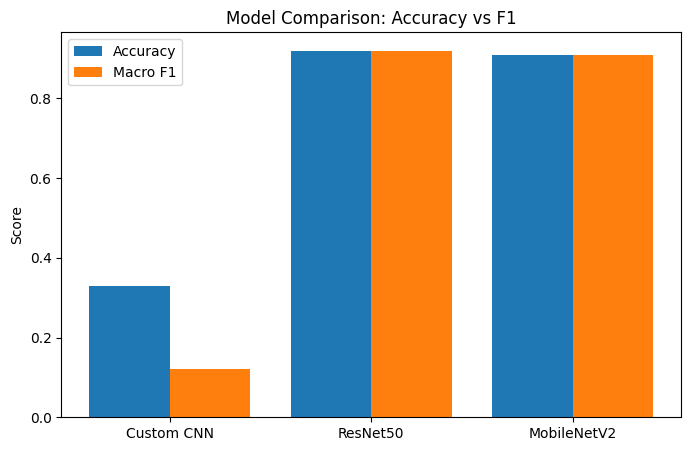

In [63]:
import matplotlib.pyplot as plt

models = ["Custom CNN", "ResNet50", "MobileNetV2"]
accuracy = [0.33, 0.92, 0.91]
f1 = [0.12, 0.92, 0.91]

x = range(len(models))

plt.figure(figsize=(8,5))
plt.bar(x, accuracy, width=0.4, label="Accuracy", align="center")
plt.bar([i+0.4 for i in x], f1, width=0.4, label="Macro F1", align="center")
# i+0.4 for i in x -->To place the Macro F1 bars nxt to the accuracy bars

plt.xticks([i+0.2 for i in x], models)
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy vs F1")
plt.legend()
plt.show()

**Predicting with MobileNetV2 Model**

/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Class order : ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
Raw scores : [0.03026374 0.01549505 0.0083523  0.9458889 ]
Predicted : Pituitary


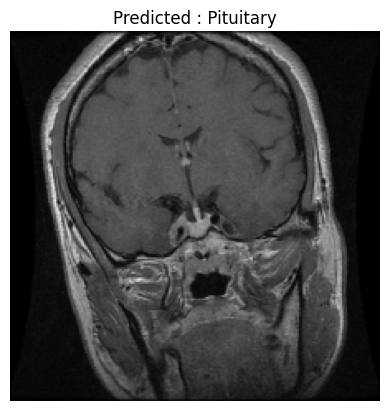

In [64]:
# Loading the best saved MobileNetV2 model
mobilenet_model = tf.keras.models.load_model("/content/drive/MyDrive/models/brain_tumor_cls/best_MobileNetV2.h5")

# Using the same class names as training
class_names = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]


image_path = '/content/drive/MyDrive/Brain Tumor MRI Image Classification/Tumour-20251124T124157Z-1-001/Tumour/test/pituitary/Tr-pi_0463_jpg.rf.b03d58e124d675c70511762322dbec5c.jpg'

# Preprocess single image
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224,224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize

# Prediction
pred = mobilenet_model.predict(img_array)
predicted_class = class_names[np.argmax(pred)]
print("Class order :", class_names)
print("Raw scores :", pred[0])
print("Predicted :", predicted_class)

# Showing image with prediction
plt.imshow(img)
plt.title(f"Predicted : {predicted_class}")
plt.axis("off")
plt.show()

**Predicting with Resnet Model**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
Class order : ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Raw scores : [1.4515070e-03 9.9711454e-01 4.5582095e-05 1.3883909e-03]
Predicted class : meningioma


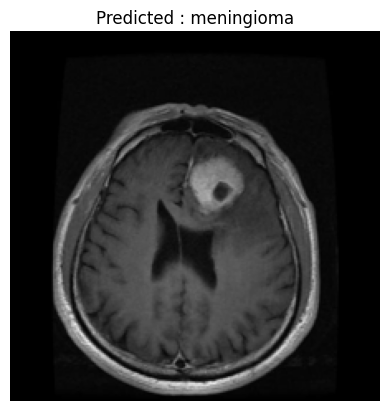

In [65]:
# Check class index mapping
class_names = ["glioma", "meningioma", "no_tumor", "pituitary"]

# Check preprocessing used in training
from tensorflow.keras.applications.resnet50 import preprocess_input

img = Image.open('/content/drive/MyDrive/Brain Tumor MRI Image Classification/Tumour-20251124T124157Z-1-001/Tumour/test/meningioma/Tr-me_0334_jpg.rf.9f27c921129a8d9d7037d58852219dfd.jpg').convert("RGB").resize((224,224))
arr = np.array(img).astype(np.float32)
arr = preprocess_input(arr)   # must match training
arr = np.expand_dims(arr, axis=0)

pred = resnet_model.predict(arr)

predicted_class = class_names[np.argmax(pred)]
print("Class order :", class_names)
print("Raw scores :", pred[0])
print("Predicted class :", predicted_class)

plt.imshow(img)
plt.title(f"Predicted : {predicted_class}")
plt.axis("off")
plt.show()

**Conclusion:**

- **Custom CNN**: Did not generalize effectively, with poor accuracy and very low F1 scores, confirming it is unsuitable for deployment.

- **ResNet50:** Achieved the highest accuracy and F1 scores during evaluation on the test images. It also demonstrated stronger generalization when applied to external images, consistently producing confident and stable predictions.

- **MobileNetV2:** Delivered competitive accuracy and F1 scores on the test images, performing close to ResNet50. However, when evaluated on external images, its predictions were occasionally less stable, with confidence spread across multiple classes, making it slightly less consistent overall.

**Recommendation:**
- **ResNet50** should be adopted as the primary model for deployment. Its proven robustness and consistent outputs make it the most dependable choice for production environments where precision and stability are paramount.

- **MobileNetV2** can be positioned as a secondary option in scenarios where efficiency and lightweight deployment are prioritized, such as mobile or edge devices. It offers strong performance but is better suited for contexts where computational constraints outweigh the need for maximum predictive confidence.